In [1]:
!pip install tensorflow

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 3063099736348261380
 xla_global_id: -1]

In [3]:
# Multiclass classification
#Predict if an asset will fail within two different intervals related to the two different decisions

`tensorflow.keras`: This imports the Keras module from TensorFlow, which provides an API for building and training deep learning models.<br>
`os`: This module provides functions for interacting with the operating system. It's commonly used for tasks such as file manipulation and directory operations.<br>
`sklearn.preprocessing`: This module from scikit-learn provides functions for preprocessing data, such as scaling, normalization, and encoding categorical variables.<br>
`sklearn.metrics`: This module contains functions for evaluating model performance, such as computing confusion matrices, recall scores, and precision scores.<br>
`tensorflow.keras.models.Sequential`: This class from Keras represents a sequential model, which is a linear stack of layers. It's used for building feedforward neural networks.<br>
`tensorflow.keras.models.load_model`: This function is used to load a pre-trained Keras model from a file.<br>
`tensorflow.keras.layers`: This module contains various types of layers that can be added to a Keras model, such as dense (fully connected) layers, dropout layers, and LSTM layers.
`multiclass_model_w1_30.h5`:The .h5 extension indicates that the model will be saved in the Hierarchical Data Format version 5 (HDF5) format, which is commonly used for storing large numerical datasets. The model will be saved with the filename **multiclass_model_w1_30.h5.**

In [4]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM

# define path to save model
model_path = 'multiclass_model_w1_30.h5'# This file then contains the already trained network, so that you don't have to retrain every time

## Data Ingestion

In [5]:
# read training data - It is the aircraft engine run-to-failure data.
train_df = pd.read_csv('PM_train.txt', sep=" ", header=None)
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [6]:
train_df.shape

(20631, 28)

`train_df.sort_values(['id','cycle'])`: This line sorts the DataFrame **train_df** first by the 'id' column and then by the 'cycle' column. It ensures that the data is ordered by engine ID and cycle number, which may be necessary for certain analyses or modeling tasks. The sorted DataFrame is then assigned back to the variable **train_df**.

In [7]:
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

In [8]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


## Data Preprocessing
data preprocessing step, particularly for labeling the data for training purposes. Let's break down what each part of the code does:


>`Data Labeling`: This part calculates the Remaining Useful Life (RUL) or Time to Failure for each engine by finding the maximum cycle number (cycle) for each engine ID (id). The result is stored in a DataFrame rul with columns 'id' and 'max'.<br>

In [9]:
#######
# TRAIN
#######
# Data Labeling - generate column RUL(Remaining Usefull Life or Time to Failure)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()


In [10]:
rul.head()

,id,cycle
0,1,192
1,2,287
2,3,179
3,4,189
4,5,269


>`Merge RUL with Training Data`:the RUL information is merged back into the original training DataFrame **train_df** based on the engine ID. This allows each row in train_df to have the corresponding maximum cycle number as well.<br>

In [11]:
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')

In [12]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,max
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,192
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,192
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,192
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,192
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,192


>`Calculate RUL`: This line calculates the RUL by subtracting the current cycle number ('cycle') from the maximum cycle number ('max') for each engine. This represents how many more cycles the engine is expected to operate before failure.<br>
>`Drop Unnecessary Columns`: After calculating RUL, the 'max' column, which was used temporarily to calculate RUL, is dropped from the DataFrame as it's no longer needed.<br>

In [13]:
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)
train_df.head(100)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,1,96,-0.0034,0.0001,100.0,518.67,642.19,1584.07,1395.16,14.62,...,2388.06,8130.69,8.4311,0.03,392,2388,100.0,38.88,23.3255,96
96,1,97,0.0035,-0.0003,100.0,518.67,642.07,1595.77,1407.81,14.62,...,2388.06,8128.74,8.4105,0.03,392,2388,100.0,39.01,23.2963,95
97,1,98,0.0006,0.0004,100.0,518.67,642.00,1591.11,1404.56,14.62,...,2388.06,8127.89,8.4012,0.03,391,2388,100.0,38.96,23.2554,94
98,1,99,-0.0005,-0.0000,100.0,518.67,642.46,1592.73,1406.13,14.62,...,2388.10,8131.77,8.4481,0.03,393,2388,100.0,38.82,23.2323,93


> `Labeling for Classification`: This part assigns labels to each data point based on the calculated RUL. It defines thresholds `w1` and `w0`, and assigns:
>> * Label 1 ('label1') as 1 if RUL is less than or equal to 'w1', and 0 otherwise.
>> * Label2 ('label2') as 1 if RUL is less than or equal to 'w1', 2 if RUL is less than or equal to 'w0', and 0 otherwise.

In [14]:
w1 = 30
w0 = 10
train_df['label1'] = np.where(train_df['RUL'] <= w1, 1, 0 )
train_df['label2'] = train_df['label1']
train_df.loc[train_df['RUL'] <= w0, 'label2'] = 2

In [15]:
train_df.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0,0


## Now I want to separate the training set into a training and validation set. I will use 80 training sets for the training and 20 training sets as evaluation sets for the PdM policy.

In [16]:
list_ID = np.arange(81,101,1) # I take the 20 last #TODO: make this random

## I separate into training and validation set before any data scaling is performed

In [17]:
validation_df = train_df.loc[train_df['id'].isin(list_ID)]

In [18]:
validation_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s15,s16,s17,s18,s19,s20,s21,RUL,label1,label2
16138,81,1,-0.0050,0.0003,100.0,518.67,642.04,1589.91,1406.63,14.62,...,8.4455,0.03,391,2388,100.0,38.87,23.3365,239,0,0
16139,81,2,0.0023,0.0002,100.0,518.67,642.65,1586.25,1407.88,14.62,...,8.4573,0.03,392,2388,100.0,38.91,23.3452,238,0,0
16140,81,3,-0.0005,0.0005,100.0,518.67,642.55,1586.42,1396.40,14.62,...,8.4522,0.03,394,2388,100.0,39.04,23.3610,237,0,0
16141,81,4,-0.0001,-0.0000,100.0,518.67,642.41,1594.89,1404.86,14.62,...,8.4403,0.03,392,2388,100.0,38.77,23.4206,236,0,0
16142,81,5,0.0024,0.0002,100.0,518.67,643.41,1590.49,1409.58,14.62,...,8.3971,0.03,392,2388,100.0,39.04,23.3311,235,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,8.4956,0.03,397,2388,100.0,38.49,22.9735,4,1,2
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,8.5139,0.03,395,2388,100.0,38.30,23.1594,3,1,2
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,8.5646,0.03,398,2388,100.0,38.44,22.9333,2,1,2
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,8.5389,0.03,395,2388,100.0,38.29,23.0640,1,1,2


In [19]:
train_df = train_df[~train_df.id.isin(list_ID)]

In [20]:
train_df.shape, validation_df.shape

((16138, 29), (4493, 29))

# Perform the min max scaling of the training data set
# use min_max_scaler.fit_transform()

>`Create a copy of the cycle column`: This line creates a new column named 'cycle_norm' in the train_df DataFrame and initializes it with the values from the original 'cycle' column. This column will be normalized later.<br>
> `Select columns for normalization`: This line selects all columns from **train_df** except 'id', 'cycle', 'RUL', 'label1', and 'label2'. These columns are the ones that will undergo normalization.


In [21]:
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL','label1','label2'])

In [22]:
cols_normalize

Index(['cycle_norm', 's1', 's10', 's11', 's12', 's13', 's14', 's15', 's16',
       's17', 's18', 's19', 's2', 's20', 's21', 's3', 's4', 's5', 's6', 's7',
       's8', 's9', 'setting1', 'setting2', 'setting3'],
      dtype='object')

> `Initialize MinMaxScaler`: This line initializes a MinMaxScaler object from the scikit-learn preprocessing module. This scaler will be used to perform Min-Max normalization.<br>
> `Perform Min-Max normalization`: This line applies Min-Max normalization to the selected columns (`cols_normalize`) of the `train_df` DataFrame.<br>
> `min_max_scaler.fit_transform(train_df[cols_normalize])` computes the Min-Max normalization for the selected columns.<br>
> The resulting normalized values are stored in a new DataFrame called `norm_train_df`, with the same index as `train_df`.

In [23]:
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)

> `Join normalized DataFrame with the original DataFrame`: This line joins the normalized DataFrame (`norm_train_df`) with the original DataFrame (`train_df`) excluding the columns that were normalized.<br>
> The resulting DataFrame `join_df` contains both the normalized columns and the original columns that were not normalized.


In [24]:
# MinMax normalization (from 0 to 1)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)


`Reorder columns`:
> * This line reorders the columns of `join_df` to match the original order of columns in `train_df`.
> * The reordered DataFrame is then assigned back to `train_df`, effectively replacing the original DataFrame with the normalized version.






In [25]:
train_df = join_df.reindex(columns = train_df.columns)

In [26]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
0,1,1,0.456647,0.166667,0.0,0.0,0.183735,0.425154,0.309757,0.0,...,0.0,0.363636,0.0,0.0,0.708661,0.725482,191,0,0,0.000000
1,1,2,0.606936,0.250000,0.0,0.0,0.283133,0.473456,0.352633,0.0,...,0.0,0.363636,0.0,0.0,0.661417,0.732001,190,0,0,0.002770
2,1,3,0.248555,0.750000,0.0,0.0,0.343373,0.386193,0.370527,0.0,...,0.0,0.181818,0.0,0.0,0.622047,0.619473,189,0,0,0.005540
3,1,4,0.537572,0.500000,0.0,0.0,0.343373,0.267715,0.331195,0.0,...,0.0,0.363636,0.0,0.0,0.566929,0.661565,188,0,0,0.008310
4,1,5,0.387283,0.333333,0.0,0.0,0.349398,0.269082,0.404625,0.0,...,0.0,0.454545,0.0,0.0,0.582677,0.704790,187,0,0,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16133,80,181,0.739884,0.666667,0.0,0.0,0.840361,0.756892,0.787812,0.0,...,0.0,0.818182,0.0,0.0,0.181102,0.369473,4,1,2,0.498615
16134,80,182,0.416185,0.833333,0.0,0.0,0.783133,0.621554,0.743754,0.0,...,0.0,0.727273,0.0,0.0,0.141732,0.151786,3,1,2,0.501385
16135,80,183,0.601156,0.500000,0.0,0.0,0.686747,0.736614,0.878629,0.0,...,0.0,0.818182,0.0,0.0,0.141732,0.037698,2,1,2,0.504155
16136,80,184,0.358382,0.666667,0.0,0.0,0.789157,0.728412,0.809926,0.0,...,0.0,0.818182,0.0,0.0,0.291339,0.127551,1,1,2,0.506925


In [27]:
train_df['label2'].unique()

array([0, 1, 2])

In [28]:
train_df['label1'].unique()

array([0, 1])

## LSTM

`Define a function to generate sequences:`
> * This function generates sequences of sensor data for each engine (`id`) in the dataset.
> * It takes three arguments:
>> * `id_df:` DataFrame containing data for a specific engine (`id`).
>> * `seq_length:` Length of the sequence window.
>> * `seq_cols:` List of column names to include in the sequences.
> * It iterates over the rows of `id_df`, creating sequences of length seq_length without padding.<br>
> * It ensures that only sequences of the specified length are considered, which is important for sequence-based modeling tasks.<br>

`Data Preparation:`
> * `data_matrix = id_df[seq_cols].values:`
>> * This line extracts the columns specified by `seq_cols` from the DataFrame `id_df` and converts them to a numpy array.<br>
>> * It selects only the relevant columns needed for creating sequences.

`Sequence Generation:`
> * `num_elements:` This line calculates the number of rows (elements) in the data_matrix.<br>
> `for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):`
>> * This is a loop that iterates over the rows of the data matrix to create sequences.<br>
>> * It uses the `zip` function to iterate over two parallel lists: one list starts from 0 to `num_elements` - `seq_length`, and the other starts from `seq_length` to `num_elements`.<br>
>> * This ensures that sequences of length `seq_length` are generated without overlap.<br>
>> * `start` and `stop` define the start and end indices of each sequence.<br>
> `yield data_matrix[start:stop, :]:`
>> * This line yields (returns) each sequence as a 2D numpy array.<br>
>> * It uses array slicing to extract the rows corresponding to the current sequence range.<br>



In [29]:
# pick a large window size of 50 cycles. This sets the length of the sequence window to 50 cycles.
sequence_length = 50

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    """ Only sequences that meet the window-length are considered, no padding is used. This means for testing
    we need to drop those which are below the window-length. An alternative would be to pad sequences so that
    we can use shorter ones """
    # for one id I put all the rows in a single matrix
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows and sequence_length is equal to 50
    # so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 -> from row 0 to row 50
    # 1 51 -> from row 1 to row 51
    # 2 52 -> from row 2 to row 52
    # ...
    # 111 191 -> from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]




In [30]:
# pick the feature columns, This selects the columns to be included in the sequences.
# sensor_cols contains the sensor data columns (s1 to s21).
sensor_cols = ['s' + str(i) for i in range(1,22)]
#sequence_cols initially contains the operational settings columns (setting1, setting2, setting3, cycle_norm).
# Then, it's extended to include the sensor data columns as well.
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

## generate sequences for each engine
> * This creates a generator expression that iterates over unique engine IDs in the training data.<br>
> * For each engine, it generates sequences using the `gen_sequence` function defined earlier.<br>
> * Each sequence is a list of sensor data, and multiple sequences are generated for each engine.<br>



In [31]:
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())


> * This concatenates all the generated sequences into a single numpy array.
> * It converts the array to `float32` data type.
> * The resulting `seq_array` contains the sequences of sensor data, with shape `(num_sequences, sequence_length, num_features)`.


In [32]:
# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
seq_array.shape

(12138, 50, 25)

In [33]:
# we always take the measurements of the last 50 cycles as input!
# Every sequence is reduced by a length of 50 (=sequence_length). We have 80 training sets, 80*50 = 4000 "less" inputs
# train_df.shape = (16138, 30)
# seq_array.shape = (12138, 50, 25)

`Function Signature:` This function efficiently generates labels for each sequence of sensor data. It ensures that the labels are correctly aligned with the sequences and handles the special case where the first sequence uses the last label as its target.





> This function takes three arguments:
>> * `id_df:` DataFrame containing data for a specific engine (id).<br>
>> * `seq_length`: Length of the sequence window.<br>
>> * `label`: List of column names representing the labels.

`Data Preparation:`
> * `data_matrix = id_df[label].values:`
>> * This line extracts the columns specified by label from the DataFrame id_df and converts them to a numpy array.<br>
>> * It selects only the relevant label(s) needed for generating sequences.<br>

`Label Generation:`
> * `num_elements:`This line calculates the number of rows (elements) in the data matrix, which corresponds to the number of labels.<br>
> * `return data_matrix[seq_length:num_elements, :]:`
>> * This line returns the labels associated with each sequence.<br>
>> * It removes the first `seq_length` labels because, for each engine (`id`), the first sequence of size `seq_length` uses the last label as its target. The previous labels are discarded.<br>
>> * All subsequent sequences for the same engine (`id`) will have one label associated with them step by step.<br>








In [34]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    # For one id I put all the labels in a single matrix.
    # For example:
    # [[1]
    # [4]
    # [1]
    # [5]
    # [9]
    # ...
    # [200]]
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    # I have to remove the first seq_length labels
    # because for one id the first sequence of seq_length size have as target
    # the last label (the previous ones are discarded).
    # All the next id's sequences will have associated step by step one label as target.
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['label2'])
             for id in train_df['id'].unique()]
label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape

(12138, 1)

In [35]:
# When modeling multi-class classification problems using neural networks,
# it is good practice to reshape the output attribute from a vector that contains values for each class value to be
# a matrix with a boolean for each class value and whether or not a given instance has that class value or not.
# This is called one hot encoding or creating dummy variables from a categorical variable.

from tensorflow.keras.utils import to_categorical

`to_categorical` is a utility function in Keras that converts class vectors (integers) to binary class matrices.<br>
`dummy_label_array = to_categorical(label_array):`This line applies one-hot encoding to the `label_array`.<br>
`label_array` contains the labels associated with each sequence, where each label represents a class or category.<br>
> * One-hot encoding converts these integer labels into binary vectors, where each vector has a length equal to the number of classes and contains a 1 in the position corresponding to the class and 0s elsewhere.





In [36]:
label_array.shape

(12138, 1)

In [37]:
dummy_label_array = to_categorical(label_array)

In [38]:
dummy_label_array

array([[1., 0., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [39]:
dummy_label_array.shape

(12138, 3)

In [40]:
type(dummy_label_array)

numpy.ndarray

In [41]:
nb_features = seq_array.shape[2]
nb_out      = dummy_label_array.shape[1]
nb_features, nb_out

(25, 3)

`Extracting Feature and Output Dimensions:`
> `nb_features:`Determines the number of features in the input sequence data.<br>
> `nb_out:`Determines the number of output classes. It's extracted from the shape of the label array.<br>

`Defining the Model Architecture:` describe in the code below.
`Compiling the Model:` `model.compile(...)` Here, `categorical_crossentropy` is used as the loss function for multi-class classification.

`Model Summary:`Prints a summary of the model architecture, including the layers and their parameters.

`Training the Model:` `model.fit(...):` Trains the model on the training data. It specifies the input data (`seq_array`) and the corresponding labels (`dummy_label_array`). Other parameters include the number of epochs, batch size, validation split, verbosity, and callbacks.<br>


`history.history.keys():` After training, this prints the keys of the history object, which contains information about training and validation metrics over each epoch.



In [42]:
# Next, we build a deep network.
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 50 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and sigmoid activation since this is a binary classification problem.
# build the network

# Initializes a sequential model, which allows you to build a model layer by layer.
model = Sequential()

#Adds an LSTM layer to the model. The first LSTM layer has 100 units, returns sequences, and takes input in the shape of (sequence_length, nb_features).
model.add(LSTM(
         input_shape=(sequence_length, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

#Adds another LSTM layer with 50 units. This layer does not return sequences, indicating it's the final LSTM layer.
model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

#Adds a dense (fully connected) layer to the model with a softmax activation function. This layer produces the output classes.
model.add(Dense(units=nb_out, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

# fit the network
history = model.fit(seq_array, dummy_label_array, epochs=10, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 3)                 153       
                                                                 
Total params: 80753 (315.44 KB)
Trainable params: 80753 (315.44 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
Epoch 1/10
58

c:\ProgramData\Anaconda3\envs\ML2023\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


58/58 - 13s - loss: 0.1850 - accuracy: 0.9264 - val_loss: 0.1562 - val_accuracy: 0.9357 - 13s/epoch - 216ms/step
Epoch 3/10
58/58 - 13s - loss: 0.1504 - accuracy: 0.9350 - val_loss: 0.1985 - val_accuracy: 0.9193 - 13s/epoch - 221ms/step
Epoch 4/10
58/58 - 13s - loss: 0.1279 - accuracy: 0.9481 - val_loss: 0.1324 - val_accuracy: 0.9489 - 13s/epoch - 220ms/step
Epoch 5/10
58/58 - 13s - loss: 0.1198 - accuracy: 0.9504 - val_loss: 0.1060 - val_accuracy: 0.9489 - 13s/epoch - 218ms/step
Epoch 6/10
58/58 - 13s - loss: 0.1182 - accuracy: 0.9526 - val_loss: 0.1181 - val_accuracy: 0.9473 - 13s/epoch - 221ms/step
Epoch 7/10
58/58 - 13s - loss: 0.1110 - accuracy: 0.9544 - val_loss: 0.1977 - val_accuracy: 0.9275 - 13s/epoch - 221ms/step
Epoch 8/10
58/58 - 14s - loss: 0.0953 - accuracy: 0.9612 - val_loss: 0.1021 - val_accuracy: 0.9539 - 14s/epoch - 246ms/step
Epoch 9/10
58/58 - 16s - loss: 0.0851 - accuracy: 0.9628 - val_loss: 0.1298 - val_accuracy: 0.9440 - 16s/epoch - 282ms/step
Epoch 10/10
58/58 -

# Every time I retrain the algorithm I get different training results, i.e., also different evaluation of the decisions

## Model Evaluation on Validation set created during the training (i.e., validation_split=0.05)

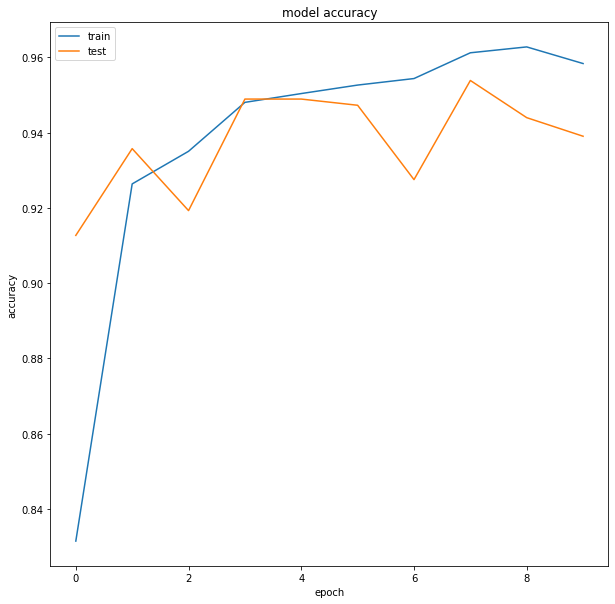

In [43]:
# summarize history for Accuracy
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("model_accuracy.png")

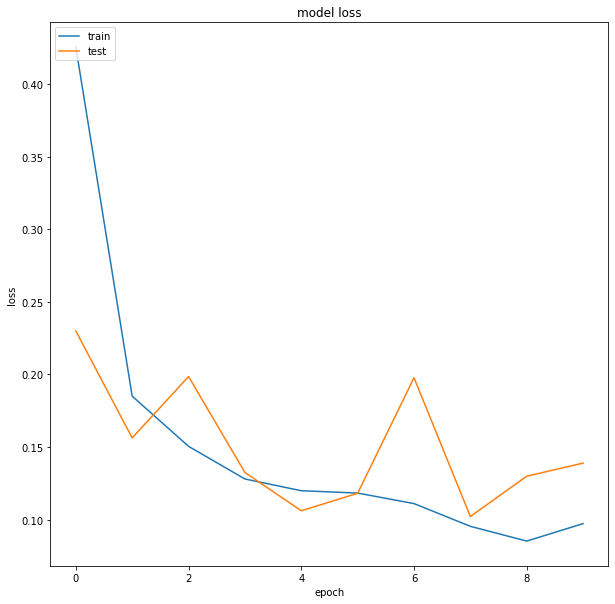

61/61 [==============================] - 6s 100ms/step - loss: 0.0890 - accuracy: 0.9623
Accurracy: 0.962267279624939


In [44]:
# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# fig_acc.savefig("model_loss.png")

# training metrics
scores = model.evaluate(seq_array, dummy_label_array, verbose=1, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

`y_pred = (model.predict(seq_array) > 0.5).astype("int32"):` Predicts the abels for the input sequences using the trained model. The predictions are hresholded at 0.5, meaning that any output probability greater than 0.5 is considered as class 1, otherwise class 0. The predictions are then converted to integers (0 or 1).<br>

`y_true = dummy_label_array:` Sets the true labels from the dummy label array, which represents the actual labels of the data.
then print the **confusion_matrix**

`cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1)):` Computes the confusion matrix using the true labels (`y_true`) and the predicted labels `(y_pred). argmax(axis=1)` is used to convert one-hot encoded labels back to their original integer form before computing the confusion matrix.




In [45]:
# make predictions and compute confusion matrix
# y_pred = model.predict_classes(seq_array,verbose=1, batch_size=200)
y_pred = (model.predict(seq_array) > 0.5).astype("int32") # this way (>0.5) the outcome goes from a probability to 0,1
y_true = dummy_label_array

# test_set = pd.DataFrame(y_pred)
# # test_set.to_csv('binary_submit_train.csv', index = None)

print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
print(cm)

380/380 [==============================] - 15s 34ms/step
Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[9635   23    0]
 [ 297 1285   18]
 [   2  122  756]]


In [46]:
import tensorflow as tf
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score, r2_score, precision_score, recall_score
import numpy as np

# Assuming y_pred and y_true are available
# y_pred = (model.predict(seq_array) > 0.5).astype("int32")  # Predictions (0 or 1)
# y_true = dummy_label_array  # True labels

# Convert y_pred and y_true to one-hot encoded if they aren't already
y_true_class = np.argmax(y_true, axis=1)
y_pred_class = np.argmax(y_pred, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true_class, y_pred_class)
print('Confusion matrix\n- x-axis is true labels.\n- y-axis is predicted labels')
print(cm)

# Function to compute F1-score, F2-score, and R2-score for each class
def calculate_metrics(y_true_class, y_pred_class):
    # F1-score for each class
    f1 = f1_score(y_true_class, y_pred_class, average=None)
    
    # F2-score with beta=2 for each class
    f2 = fbeta_score(y_true_class, y_pred_class, beta=2.0, average=None)
    
    # R2-score (optional for classification tasks, but usually used for regression tasks)
    r2 = r2_score(y_true_class, y_pred_class)
    
    return f1, f2, r2

# Compute F1, F2, and R2 scores for each class
f1, f2, r2 = calculate_metrics(y_true_class, y_pred_class)

# Print the results
print("F1-score for each class:", f1)
print("F2-score for each class (beta=2.0):", f2)
print("R2-score:", r2)

# Additional classification metrics (optional)
precision = precision_score(y_true_class, y_pred_class, average=None)
recall = recall_score(y_true_class, y_pred_class, average=None)

print("Precision for each class:", precision)
print("Recall for each class:", recall)


Confusion matrix
- x-axis is true labels.
- y-axis is predicted labels
[[9635   23    0]
 [ 297 1285   18]
 [   2  122  756]]
F1-score for each class: [0.98356472 0.84818482 0.91414752]
F2-score for each class (beta=2.0): [0.9919491  0.82056194 0.88029809]
R2-score: 0.888302721987315
Precision for each class: [0.96990135 0.8986014  0.97674419]
Recall for each class: [0.99761855 0.803125   0.85909091]


## Second PdM policy evaluation on the validation set.

For each validation set, I need to give the on-line sensor data as input to the trained LSTM.


In [47]:
if os.path.isfile(model_path):
    estimator = load_model(model_path)

In [48]:
# Assumptions for the costs, taken by the 2019 RESS paper
C_p    = 100
C_c    = 1000
C_unav = 10
C_inv  = 1
DT     = 10  # Decisions can be taken every DT=10
L      = 20  # lead time

In [49]:
array_decisions = np.arange(0,400,10) # decisions can only be made every DT = 10 cycles

In [50]:
# estimator.predict(seq_array_validation_k).reshape(3) returns a vector with 3 elements
# [Pr(RUL>w1), Pr(w0<RUL<=w1), Pr(RUL<=w0)]

In [51]:
validation_df['cycle_norm'] = validation_df['cycle']

In [52]:
validation_df.shape

(4493, 30)

In [53]:
validation_df.head(242)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s16,s17,s18,s19,s20,s21,RUL,label1,label2,cycle_norm
16138,81,1,-0.0050,0.0003,100.0,518.67,642.04,1589.91,1406.63,14.62,...,0.03,391,2388,100.0,38.87,23.3365,239,0,0,1
16139,81,2,0.0023,0.0002,100.0,518.67,642.65,1586.25,1407.88,14.62,...,0.03,392,2388,100.0,38.91,23.3452,238,0,0,2
16140,81,3,-0.0005,0.0005,100.0,518.67,642.55,1586.42,1396.40,14.62,...,0.03,394,2388,100.0,39.04,23.3610,237,0,0,3
16141,81,4,-0.0001,-0.0000,100.0,518.67,642.41,1594.89,1404.86,14.62,...,0.03,392,2388,100.0,38.77,23.4206,236,0,0,4
16142,81,5,0.0024,0.0002,100.0,518.67,643.41,1590.49,1409.58,14.62,...,0.03,392,2388,100.0,39.04,23.3311,235,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16375,81,238,0.0011,-0.0004,100.0,518.67,643.54,1598.68,1428.15,14.62,...,0.03,395,2388,100.0,38.48,23.0828,2,1,2,238
16376,81,239,0.0068,0.0005,100.0,518.67,643.84,1602.45,1429.38,14.62,...,0.03,398,2388,100.0,38.30,23.0611,1,1,2,239
16377,81,240,-0.0026,-0.0003,100.0,518.67,644.01,1601.01,1423.61,14.62,...,0.03,397,2388,100.0,38.37,23.0289,0,1,2,240
16378,82,1,0.0000,-0.0002,100.0,518.67,641.73,1582.64,1401.58,14.62,...,0.03,391,2388,100.0,38.84,23.4584,213,0,0,1


## Second PdM policy evaluation on a the whole validation data set (ids 81 to 100)


In [54]:
costs_rep_array   = np.zeros(20) # An array to store costs related to replacements.

costs_delay_array = np.zeros(20) # An array to store costs related to delays.
costs_stock_array = np.zeros(20) # An array to store costs related to stock.

t_LC_array        = np.zeros(20) # An array to store lead time.
t_order_array     = np.zeros(20) # An array to store order time.

> 1. Initializes a counter variable to 0.
> 2. Iterates over unique IDs in the `validation_df` DataFrame.
> 3. For each ID:
>> * Sets flags for preventive replacement and ordering to False.<br>
>> * Iterates over cycles within the range of the DataFrame.<br>
>> * Checks if the current cycle is in the `array_decisions`.<br>
>> * If it is, preprocesses the validation data for the LSTM model.<br>
>> * Predicts the probability of RUL being smaller than w1 and DT (decision time) using the trained model.<br>
>> * Evaluates decision heuristics:
>>> * If no order has been placed yet and the cost of preventive replacement is less than or equal to the cost of waiting until `w1`, orders the component and sets the order time.<br>
>>> * If the cost of preventive replacement is less than or equal to the cost of waiting until `DT`, performs preventive replacement, calculates related costs, and breaks the loop.<br>
>> If preventive replacement is not performed:
>>> * Sets the component failure time to the last cycle in the ID's data.<br>
>>> * Sets replacement costs to `C_c`.<br>
>>> * Calculates delay costs based on whether an order has been placed.<br>
>> * Prints diagnostic information for each iteration.
>> * Increments the counter.


This code essentially simulates a decision-making process for component maintenance based on predictive models and cost considerations.








In [55]:
def calculate_probabilities(estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols):
    
    for id in pdm_df['id'].unique():
        # Loop through each decision point
        for cycle in range(pdm_df[pdm_df['id']==id].shape[0]-params+1):
            if cycle in array_decisions:
                # Prepare data                           
                norm_pdm_df = pd.DataFrame(scaler.transform(pdm_df[pdm_df['id']==id][cols_normalize_train][:params+cycle]),
                 columns=cols_normalize_train,
                 index=pdm_df[pdm_df['id']==id][:params+cycle].index)
                print(norm_pdm_df.shape)
                join_df = pdm_df[pdm_df['id']==id][:params+cycle][pdm_df[pdm_df['id']==id][:params+cycle].columns.difference(cols_normalize_train)].join(norm_pdm_df)
                pdm_df_eval_online = join_df.reindex(columns = pdm_df[pdm_df['id']==id][cycle:params+cycle].columns)

                seq_array_test_k = pdm_df_eval_online[sequence_cols].values[cycle:params+cycle]
                seq_array_test_k = np.asarray(seq_array_test_k).astype(np.float32).reshape(1,params, len(sequence_cols))
                                
                
                probabilities    = estimator.predict(seq_array_test_k).reshape(3)

                # Predict
                #with torch.no_grad():
                 #   outputs = estimator(seq_tensor).squeeze()
                #probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                print("probabilities: ", probabilities)
                #print("seq_array_test_k: ", seq_array_test_k)
                
                
    return probabilities

probabilities= calculate_probabilities(estimator, validation_df, min_max_scaler, sequence_length, cols_normalize, sequence_cols)

(50, 25)
1/1 [==============================] - 1s 1s/step
probabilities:  [9.9907434e-01 8.3883211e-04 8.6837339e-05]
(60, 25)
1/1 [==============================] - 0s 39ms/step
probabilities:  [9.9951398e-01 4.2986262e-04 5.6077701e-05]
(70, 25)
1/1 [==============================] - 0s 36ms/step
probabilities:  [9.993894e-01 5.447662e-04 6.573278e-05]
(80, 25)
1/1 [==============================] - 0s 41ms/step
probabilities:  [9.9913114e-01 7.8822148e-04 8.0687161e-05]
(90, 25)
1/1 [==============================] - 0s 38ms/step
probabilities:  [9.9884629e-01 1.0590623e-03 9.4649884e-05]
(100, 25)
1/1 [==============================] - 0s 34ms/step
probabilities:  [9.9941695e-01 5.2194064e-04 6.1112762e-05]
(110, 25)
1/1 [==============================] - 0s 34ms/step
probabilities:  [9.9928683e-01 6.4404303e-04 6.9185109e-05]
(120, 25)
1/1 [==============================] - 0s 33ms/step
probabilities:  [9.9884975e-01 1.0600629e-03 9.0152011e-05]
(130, 25)
1/1 [===================

In [56]:
def calculate_probabilities_for_pdm_policy_1_With_ordering(estimator, validation_df, sequence_length, cols_normalize, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv):
    counter = 0
    for id in validation_df['id'].unique():
        print('ID:', id)
        preventive_replacement = False
        order                  = False

        for cycle in range(validation_df[validation_df['id']==id].shape[0]-sequence_length+1):

            if cycle in array_decisions:

                norm_validation_df = pd.DataFrame(min_max_scaler.transform(validation_df[validation_df['id']==id][cols_normalize][:sequence_length+cycle]),
                     columns=cols_normalize,
                     index=validation_df[validation_df['id']==id][:sequence_length+cycle].index)
                print(norm_validation_df.shape)
                join_df = validation_df[validation_df['id']==id][:sequence_length+cycle][validation_df[validation_df['id']==id][:sequence_length+cycle].columns.difference(cols_normalize)].join(norm_validation_df)
                validation_df_eval_online = join_df.reindex(columns = validation_df[validation_df['id']==id][cycle:sequence_length+cycle].columns)

                seq_array_validation_k = validation_df_eval_online[sequence_cols].values[cycle:sequence_length+cycle]
                seq_array_validation_k = np.asarray(seq_array_validation_k).astype(np.float32).reshape(1,sequence_length, nb_features)
                #print(seq_array_validation_k.shape)
                prob_RUL_smaller_DT    = estimator.predict(seq_array_validation_k).reshape(3)[2]
                prob_RUL_smaller_w1    = estimator.predict(seq_array_validation_k).reshape(3)[1]

                print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
                print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)


                # evaluate decision heuristics
                if order == False:
                    if C_p <= prob_RUL_smaller_w1*C_c:
                        print('prob_RUL_smaller_w1:', prob_RUL_smaller_w1)
                        print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)
                        t_order_array[counter] = sequence_length+cycle
                        order = True
                        print('component ordering at cycle:', t_order_array[counter])

                if C_p <= prob_RUL_smaller_DT*C_c:
                    print('prob_RUL_smaller_DT:', prob_RUL_smaller_DT)

                    t_LC_array[counter] = sequence_length+cycle
                    costs_rep_array[counter] = C_p
                    print('preventive replacement informed at cycle:', t_LC_array[counter])
                    # print('component lifecycle:', t_LC)
                    preventive_replacement = True
                    costs_delay_array[counter] = max(t_order_array[counter]+L-t_LC_array[counter], 0) * C_unav
                    costs_stock_array[counter]  = max(t_LC_array[counter] -(t_order_array[counter]+L), 0)*C_inv
                    # print('delay time', max(t_order+L-t_LC, 0))
                    # print('cost_delay_id:',cost_delay_id)
                    # print('cost of stock:', cost_stock_id)
                    break

        if preventive_replacement == False:
            t_LC_array[counter] = validation_df[validation_df['id']==id]['cycle'].iloc[-1]
            print('Component failure at t:', t_LC_array[counter])
            costs_rep_array[counter] = C_c

            if order == False:
                costs_delay_array[counter] = L * C_unav
            else:
                costs_delay_array[counter] = max(t_order_array[counter]+L-t_LC_array[counter], 0) * C_unav
                costs_stock_array[counter] = max(t_LC_array[counter] -(t_order_array[counter]+L), 0)*C_inv

        print('True failure:', validation_df[validation_df['id']==id]['cycle'].iloc[-1])
        print('-----------------------------------------')
        counter+=1
    
    return t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array
        

t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array=calculate_probabilities_for_pdm_policy_1_With_ordering(estimator, validation_df, sequence_length, cols_normalize, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv, device)

NameError: name 'device' is not defined

In [ ]:
costs_rep_array

In [ ]:
costs_delay_array

In [ ]:
costs_stock_array

In [ ]:
costs_tot = costs_rep_array+costs_delay_array+costs_stock_array

In [ ]:
costs_tot

In [ ]:
t_LC_array

In [ ]:
t_order_array

In [ ]:
# Example usage
def calculate_T_R_perfect(pdm_df, id, DT=10):
    # Retrieve the perfect failure time for the ith component
    T_F_perfect = pdm_df[pdm_df['id'] == id]['cycle'].iloc[-1]
    
    # Calculate k as the largest integer such that k * DT < T_F_perfect
    k = int(T_F_perfect // DT)  # Use floor division
    T_R_perfect = k * DT  # Calculate T_R_perfect
    
    return T_R_perfect

def calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df):
    # Calculate the average costs and lifecycle times
    average_costs = (np.mean(costs_rep_array) + np.mean(costs_delay_array) + np.mean(costs_stock_array))
    average_t_LC_array = np.mean(t_LC_array)

    # Calculate T_R_perfect for each component and then find the average
    T_R_perfect_array = []
    for id in pdm_df['id'].unique():
        T_R_perfect = calculate_T_R_perfect(pdm_df, id, DT=10)
        T_R_perfect_array.append(T_R_perfect)

    average_T_R_perfect = np.mean(T_R_perfect_array)

    # Calculate the first part of the numerator
    numerator_part1 = average_costs / average_t_LC_array

    # Calculate the second part of the numerator
    numerator_part2 = C_p / average_T_R_perfect

    # Calculate the full numerator
    numerator = numerator_part1 - numerator_part2

    # Calculate the denominator
    denominator = C_p / average_T_R_perfect

    # Calculate the decision-oriented metric as a percentage
    M_hat = (numerator / denominator) * 100 if denominator != 0 else 0  # Avoid division by zero

    return M_hat

def calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df):
    # Calculate the average costs and lifecycle times
    average_costs = np.mean(costs_rep_array)
    average_t_LC_array = np.mean(t_LC_array)

    # Calculate T_R_perfect for each component and then find the average
    T_R_perfect_array = []
    for id in pdm_df['id'].unique():
        T_R_perfect = calculate_T_R_perfect(pdm_df, id, DT=10)
        T_R_perfect_array.append(T_R_perfect)

    average_T_R_perfect = np.mean(T_R_perfect_array)

    # Calculate the first part of the numerator
    numerator_part1 = average_costs / average_t_LC_array

    # Calculate the second part of the numerator
    numerator_part2 = C_p / average_T_R_perfect

    # Calculate the full numerator
    numerator = numerator_part1 - numerator_part2

    # Calculate the denominator
    denominator = C_p / average_T_R_perfect

    # Calculate the decision-oriented metric as a percentage
    M_hat = (numerator / denominator) * 100 if denominator != 0 else 0  # Avoid division by zero

    return M_hat

# Usage remains the same
# Range of C_p values
C_p_values = np.array([100, 200, 300, 400, 500, 600, 700, 800, 900, 1000])
C_c = 1000  # Constant corrective replacement cost
M_hat_Policy1_With_ordering = []

#M_hat_Policy1_Without_ordering = []

#M_hat_Policy2_With_ordering = []
#M_hat_Policy2_Without_ordering = []

#M_hat_Policy3_With_ordering = []
#M_hat_Policy3_Without_ordering = []

# Calculate M_hat for each C_p
for C_p in C_p_values:
    #Call the function to get updated arrays for policy1 with ordering  
    t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_1_With_ordering(estimator, validation_df, sequence_length, cols_normalize, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv, device)

    # Calculate M_hat using the updated arrays
    M_hat1 = calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df)
    M_hat_Policy1_With_ordering.append(M_hat1)
    
    """
    # Call the function to get updated arrays for policy1 without ordering
    t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, prob_RUL_smaller_DT_dict, replacement_probs_dict = calculate_probabilities_for_pdm_policy_1_Without_ordering(estimator, pdm_df,scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv, device)

    # Calculate M_hat using the updated arrays
    M_hat2 = calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df)
    M_hat_Policy1_Without_ordering.append(M_hat2)
    
    
    
    # Call the function to get updated arrays for policy2 with ordering
    t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_2_With_ordering(estimator, pdm_df,scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv, device)
    
    # Calculate M_hat using the updated arrays
    M_hat3 = calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df)
    M_hat_Policy2_With_ordering.append(M_hat3)
    
    
    # Call the function to get updated arrays for policy2 without ordering
    t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, optimal_replacement_times, rul_distributions = calculate_probabilities_for_pdm_policy_2_Without_ordering(
    estimator, pdm_df, scaler, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv, device)
    
    # Calculate M_hat using the updated arrays
    M_hat4 = calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df)
    M_hat_Policy2_Without_ordering.append(M_hat4)
    
    
    # Call the function to get updated arrays for policy3 with ordering                   
    t_order_array, t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array = calculate_probabilities_for_pdm_policy_3_With_ordering(estimator, pdm_df,train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L,DT, C_unav, C_inv, device)

    # Calculate M_hat using the updated arrays
    M_hat5 = calculate_decision_metric_with_ordering(costs_rep_array, costs_delay_array, costs_stock_array, t_LC_array, C_p, pdm_df)
    M_hat_Policy3_With_ordering.append(M_hat5)
    
    # Call the function to get updated arrays for policy3 without ordering
    t_LC_array, costs_rep_array, costs_delay_array, costs_stock_array, T_R_k_optimal_dict = calculate_probabilities_for_pdm_policy_3_Without_ordering(
    estimator, pdm_df, scaler, train_df, params, cols_normalize_train, sequence_cols, C_p, C_c, L, DT, C_unav, C_inv, device)

    # Calculate M_hat using the updated arrays
    M_hat6 = calculate_decision_metric_without_ordering(costs_rep_array,  t_LC_array, C_p, pdm_df)
    M_hat_Policy3_Without_ordering.append(M_hat6)    
    """
    
    

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate C_p/C_c ratios
C_p_C_c_ratios = C_p_values / C_c

# Plotting the results
plt.figure(figsize=(12, 8))

policies = [
    (M_hat_Policy1_With_ordering, 'Policy 1 With Ordering')
]

for data, label in policies:
    plt.plot(C_p_C_c_ratios, data, marker='o', label=label)
    print(f"{label} data: {data}")  # Print data for debugging

plt.title('Decision Metric M_hat% vs C_p/C_c Ratio')
plt.xlabel('C_p/C_c Ratio')
plt.ylabel('Decision Metric M_hat%')
plt.legend()
plt.yscale("log")
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.xticks(C_p_C_c_ratios)  # Set x-ticks to the calculated ratios
plt.axhline(0, color='black', lw=0.5, ls='--')  # Add a horizontal line at y=0

# Adjust y-axis limits to ensure all data is visible
plt.ylim(bottom=max(1, plt.ylim()[0]), top=plt.ylim()[1]*1.1)

# Save the plot as an image
plt.savefig('decision_metric_plot.png', dpi=300, bbox_inches='tight')

plt.show()

### This code calculates the expected cost per unit time using the LSTM model. It computes the mean of the total costs divided by the mean of the time to component failure (t_LC_array). This metric gives an estimate of the average cost incurred per unit time in the system, considering both maintenance and operational costs.

In [ ]:
expected_cost_LSTM = np.mean(costs_tot) / np.mean(t_LC_array)
expected_cost_LSTM

This code segment calculates the expected cost per unit time assuming perfect prognostics.
`1. Perfect Prognostics Calculation:`
> * It initializes an array `t_LC_perfect_array` to store the time of component failure for each unit in the validation dataset. This is calculated by dividing the last observed cycle number by the decision interval DT and then flooring the result to get the last decision cycle before failure.
> * The loop iterates over each unique ID in the validation dataset, calculates the time of component failure for each unit, and stores it in
`t_LC_perfect_array`.<br>
> * `math.floor()` is used to round down the result to the nearest multiple of `DT`.
> * Finally, the loop increments the counter for each unit.<br>

`2. Cost Calculation:`
> * `costs_perfect_array` is initialized with a value of `C_p`, representing the cost of preventive replacements. In a perfect scenario, only preventive replacements are made.
> * This array holds the same cost value for each unit in the validation dataset.

`3. Expected Cost Calculation:`
> * `expected_cost_perfect` is calculated by taking the mean of `costs_perfect_array` and dividing it by the mean of `t_LC_perfect_array`.
> * This calculation provides an estimate of the average cost per unit time assuming perfect prognostics, where components are replaced preventively at regular intervals.









In [ ]:
# Perfect prognostics
import math
t_LC_perfect_array  = np.zeros(20)
counter=0
for id in validation_df['id'].unique():
    t_LC_perfect_array[counter] = math.floor(validation_df[validation_df['id']==id]['cycle'].iloc[-1] /DT) * DT
    counter+=1

costs_perfect_array = np.ones(20)*C_p # a perfect policy will only lead to preventive replacements

expected_cost_perfect = np.mean(costs_perfect_array)/np.mean(t_LC_perfect_array)
expected_cost_perfect


In [ ]:
t_LC_perfect_array

In [ ]:
# evaluation of the metric defined in the paper
M = (expected_cost_LSTM - expected_cost_perfect) / expected_cost_perfect
M # it obtains a very small value

In [ ]:
M*100